In [50]:
import random
random.seed(19876750)
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import tree, metrics
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from yellowbrick.classifier import ROCAUC
import torch
from torch import nn, optim
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '0' ]

In [2]:
data = pd.read_csv("musicData.csv")
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

<font size="5"> <font color='blue'> Find rows that don't contain any data and discard them

In [4]:
missing = data.isna().any(axis=1)
print(data[missing])

       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN   
10001           NaN          NaN     NaN               NaN  NaN       NaN   
10002           NaN          NaN     NaN               NaN  NaN       NaN   
10003           NaN          NaN     NaN               NaN  NaN       NaN   
10004           NaN          NaN     NaN               NaN  NaN       NaN   

       loudness mode  speechiness tempo obtained_date  valence music_genre  
10000       NaN  NaN          NaN

In [5]:
data1 = data[~missing].reset_index(drop=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

<font size="5"> <font color='blue'> Count the number of songs with missing duration ("-1") or tempo data ("?")

In [6]:
print("{} songs have missing duration data.".format(sum(data1['duration_ms']==-1)))
print("{} songs have missing tempo data.".format(sum(data1['tempo']=="?")))
print("{} songs have both data missing.".format(sum((data1["duration_ms"]==-1) & (data1['tempo']=="?"))))

4939 songs have missing duration data.
4980 songs have missing tempo data.
479 songs have both data missing.


<font size="5"> <font color='blue'> Replace them with the mean values of duration and tempo

In [7]:
missing_tempo = data1['tempo'] == "?"
mean_tempo = data1[~missing_tempo]['tempo'].astype('float64').mean()
print(mean_tempo)

119.95296059529099


In [8]:
data1['tempo'] = data1['tempo'].replace("?", mean_tempo)

In [9]:
missing_duration = data1['duration_ms'] == -1
mean_duration = data1[~missing_duration]['duration_ms'].mean()
print(mean_duration)

245503.54146601274


In [10]:
data1['duration_ms'] = data1['duration_ms'].replace(-1 , mean_duration)

In [11]:
data1['tempo'] = data1['tempo'].astype('float64')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  float64
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

<font size="5"> <font color='blue'> Dummy code the mode and key columns (one-hot encoding)

In [12]:
# Dummy code the 'mode' column
dummy_coded_mode = pd.get_dummies(data1['mode'], prefix='mode', dtype=int)

# Concatenate the dummy columns with the original DataFrame
data1 = pd.concat([data1, dummy_coded_mode], axis=1)

# Drop the original 'mode' column 
data1.drop(columns=['mode'], inplace=True)

data1.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre,mode_Major,mode_Minor
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,245503.541466,0.941,0.792000,A#,0.1150,-5.201,0.0748,100.889000,4-Apr,0.759,Electronic,0,1
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.000000,0.890,0.950000,D,0.1240,-7.043,0.0300,115.002000,4-Apr,0.531,Electronic,0,1
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.000000,0.755,0.011800,G#,0.5340,-4.617,0.0345,127.994000,4-Apr,0.333,Electronic,1,0
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.000000,0.700,0.002530,C#,0.1570,-4.498,0.2390,128.014000,4-Apr,0.270,Electronic,1,0
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.000000,0.587,0.909000,F#,0.1570,-6.266,0.0413,145.036000,4-Apr,0.323,Electronic,1,0
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.000000,0.731,0.854000,D,0.2160,-10.517,0.0412,119.952961,4-Apr,0.614,Electronic,0,1
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.000000,0.803,0.000008,B,0.1060,-4.294,0.3510,149.995000,4-Apr,0.230,Electronic,1,0
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.000000,0.706,0.903000,G,0.0635,-9.339,0.0484,120.008000,4-Apr,0.761,Electronic,0,1
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.000000,0.921,0.000276,F,0.1780,-3.175,0.2680,149.948000,4-Apr,0.273,Electronic,0,1
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.000000,0.731,0.011200,A,0.1110,-7.091,0.1730,139.933000,4-Apr,0.203,Electronic,0,1


In [13]:
# Dummy code the 'key' column
dummy_coded_key = pd.get_dummies(data1['key'], prefix='key', dtype=int)

# Concatenate the dummy columns with the original DataFrame
data1 = pd.concat([data1, dummy_coded_key], axis=1)

# Drop the original 'key' column
data1.drop(columns=['key'], inplace=True)

data1.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre,mode_Major,mode_Minor,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,245503.541466,0.941,0.792000,0.1150,-5.201,0.0748,100.889000,4-Apr,0.759,Electronic,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.000000,0.890,0.950000,0.1240,-7.043,0.0300,115.002000,4-Apr,0.531,Electronic,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.000000,0.755,0.011800,0.5340,-4.617,0.0345,127.994000,4-Apr,0.333,Electronic,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.000000,0.700,0.002530,0.1570,-4.498,0.2390,128.014000,4-Apr,0.270,Electronic,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.000000,0.587,0.909000,0.1570,-6.266,0.0413,145.036000,4-Apr,0.323,Electronic,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.000000,0.731,0.854000,0.2160,-10.517,0.0412,119.952961,4-Apr,0.614,Electronic,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.000000,0.803,0.000008,0.1060,-4.294,0.3510,149.995000,4-Apr,0.230,Electronic,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.000000,0.706,0.903000,0.0635,-9.339,0.0484,120.008000,4-Apr,0.761,Electronic,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.000000,0.921,0.000276,0.1780,-3.175,0.2680,149.948000,4-Apr,0.273,Electronic,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.000000,0.731,0.011200,0.1110,-7.091,0.1730,139.933000,4-Apr,0.203,Electronic,0,1,1,0,0,0,0,0,0,0,0,0,0,0


<font size="5"> <font color='blue'> Transform music_genre into numerical labels (from 0 to 9 for 10 genres)

In [14]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'music_genre' column
data1['music_genre'] = label_encoder.fit_transform(data1['music_genre'])

# Display the DataFrame with the replaced 'music_genre' column
data1.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre,mode_Major,mode_Minor,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,245503.541466,0.941,0.792000,0.1150,-5.201,0.0748,100.889000,4-Apr,0.759,5,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.000000,0.890,0.950000,0.1240,-7.043,0.0300,115.002000,4-Apr,0.531,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.000000,0.755,0.011800,0.5340,-4.617,0.0345,127.994000,4-Apr,0.333,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.000000,0.700,0.002530,0.1570,-4.498,0.2390,128.014000,4-Apr,0.270,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.000000,0.587,0.909000,0.1570,-6.266,0.0413,145.036000,4-Apr,0.323,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.000000,0.731,0.854000,0.2160,-10.517,0.0412,119.952961,4-Apr,0.614,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.000000,0.803,0.000008,0.1060,-4.294,0.3510,149.995000,4-Apr,0.230,5,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.000000,0.706,0.903000,0.0635,-9.339,0.0484,120.008000,4-Apr,0.761,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.000000,0.921,0.000276,0.1780,-3.175,0.2680,149.948000,4-Apr,0.273,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.000000,0.731,0.011200,0.1110,-7.091,0.1730,139.933000,4-Apr,0.203,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0


<font size="5"> <font color='blue'> Standardize the numerical non-categorical data

In [15]:
numerical_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness','speechiness','tempo','valence']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1[numerical_columns])
data1[numerical_columns] = scaled_data
data1.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre,mode_Major,mode_Minor,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,32894.0,Röyksopp,Röyksopp's Night Out,-1.108003,-0.883886,0.524878,2.751216e-16,1.289876,1.875809,-0.488113,0.638132,-0.185322,-6.556731e-01,4-Apr,1.225073,5,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,46652.0,Thievery Corporation,The Shining Path,-0.850633,-0.860390,0.356933,-2.572242e-01,1.097101,2.361357,-0.432433,0.339248,-0.627258,-1.702800e-01,4-Apr,0.302431,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,30097.0,Dillon Francis,Hurricane,-1.043661,-0.888632,0.345737,-2.825585e-01,0.586813,-0.521812,2.104140,0.732892,-0.582867,2.765581e-01,4-Apr,-0.498812,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,62177.0,Dubloadz,Nitro,-0.657606,-0.823184,1.207853,-7.432841e-01,0.378918,-0.550300,-0.228269,0.752201,1.434452,2.772460e-01,4-Apr,-0.753752,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24907.0,What So Not,Divide & Conquer,-0.786291,-0.883974,0.446504,-2.186933e-01,-0.048212,2.235361,-0.228269,0.465324,-0.515787,8.626892e-01,4-Apr,-0.539278,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,89064.0,Axel Boman,Hello,0.178845,-0.882275,1.101488,2.589815e+00,0.496095,2.066341,0.136749,-0.224445,-0.516774,4.887586e-16,4-Apr,0.638305,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,43760.0,Jordan Comolli,Clash,0.114502,-0.812930,0.077025,-2.939495e-01,0.768248,-0.558051,-0.543794,0.785302,2.539292,1.033246e+00,4-Apr,-0.915620,5,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,30738.0,Hraach,Delirio,-0.078525,-0.810586,1.403789,1.612969e+00,0.401597,2.216922,-0.806732,-0.033302,-0.445748,1.892988e-03,4-Apr,1.233167,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,84950.0,Kayzo,NEVER ALONE,-0.335894,-0.888837,-0.275659,4.470985e-01,1.214278,-0.557226,-0.098347,0.966872,1.720527,1.031629e+00,4-Apr,-0.741612,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9,56950.0,Shlump,Lazer Beam,-1.429715,-0.870234,0.110614,-3.847750e-01,0.496095,-0.523656,-0.512861,0.331460,0.783386,6.871801e-01,4-Apr,-1.024880,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0


<font size="5"> <font color='blue'> Ensure the number of songs belonging to each genre is the same as expected (5000 each)

In [16]:
for i in range(0, 10):
    print (sum(data1['music_genre'] == i))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


<font size="5"> <font color='blue'> Train test split: 4500 songs from each genre as the training set and 500 songs from each genre make up the testing set

In [17]:
# Group the data by 'music_genre'
grouped = data1.groupby('music_genre')

# Initialize empty lists to store train/test data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split each genre group into train/test sets
for _, group in grouped:
    dropped = ['instance_id', 'artist_name','track_name','obtained_date','music_genre']
    X_group = group.drop(columns = dropped)  # Features (all columns except 'music_genre')
    y_group = group['music_genre']  # Labels (only the 'music_genre' column)
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y_group, train_size=4500, test_size=500)
    X_train_list.append(X_train_group)
    X_test_list.append(X_test_group)
    y_train_list.append(y_train_group)
    y_test_list.append(y_test_group)

# Concatenate the train/test sets from all genre groups
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (45000, 25)
X_test shape: (5000, 25)
y_train shape: (45000,)
y_test shape: (5000,)


<font size="5"> <font color='blue'> Dimensionality Reduction and Clustering with TSNE and UMAP for 2D visualization of data

(45000, 2)
2.798527240753174


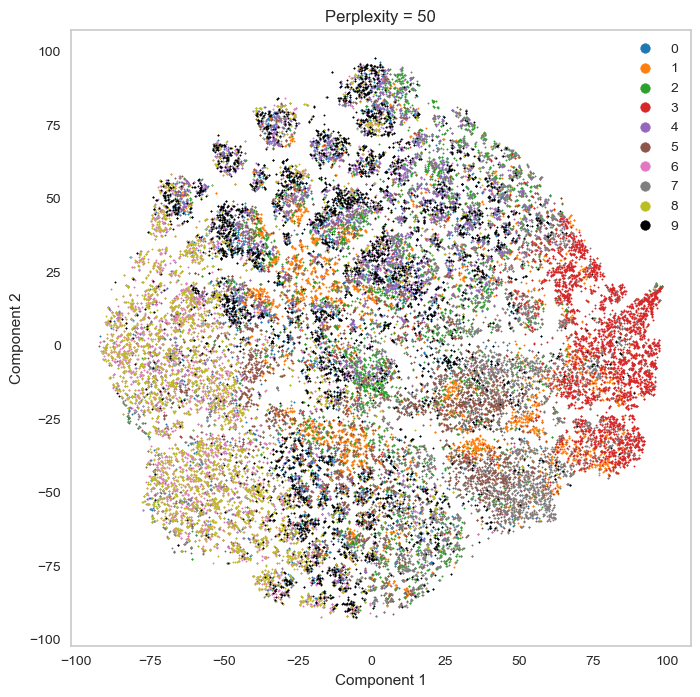

In [118]:
tsne = TSNE(n_components=2, perplexity=50)
X_train_embedded = tsne.fit_transform(X_train)
print(X_train_embedded.shape)
print(tsne.kl_divergence_)

target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_train_embedded[y_train == i, 0], X_train_embedded[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("Perplexity = 50")
plt.show()

(45000, 2)
2.8023784160614014


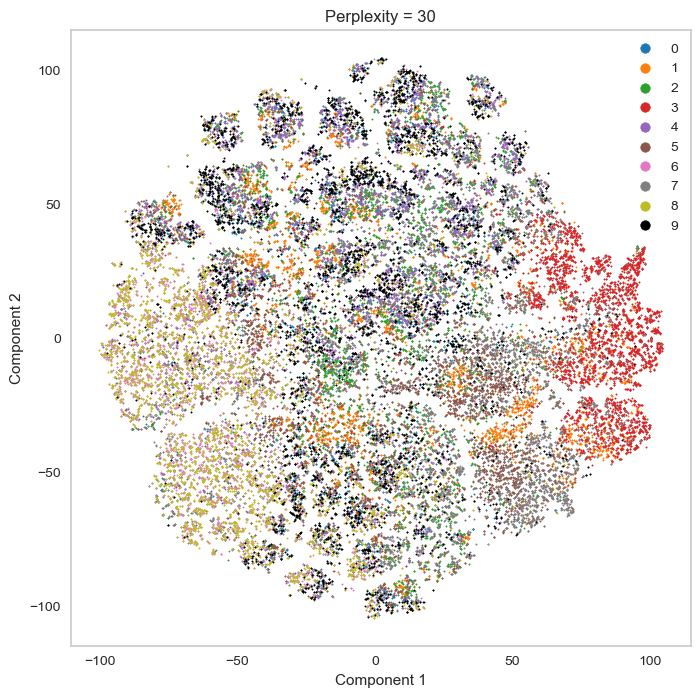

In [117]:
tsne = TSNE(n_components=2, perplexity=30)
X_train_embedded = tsne.fit_transform(X_train)
print(X_train_embedded.shape)
print(tsne.kl_divergence_)

target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_train_embedded[y_train == i, 0], X_train_embedded[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("Perplexity = 30")
plt.show()

(45000, 2)
2.718651056289673


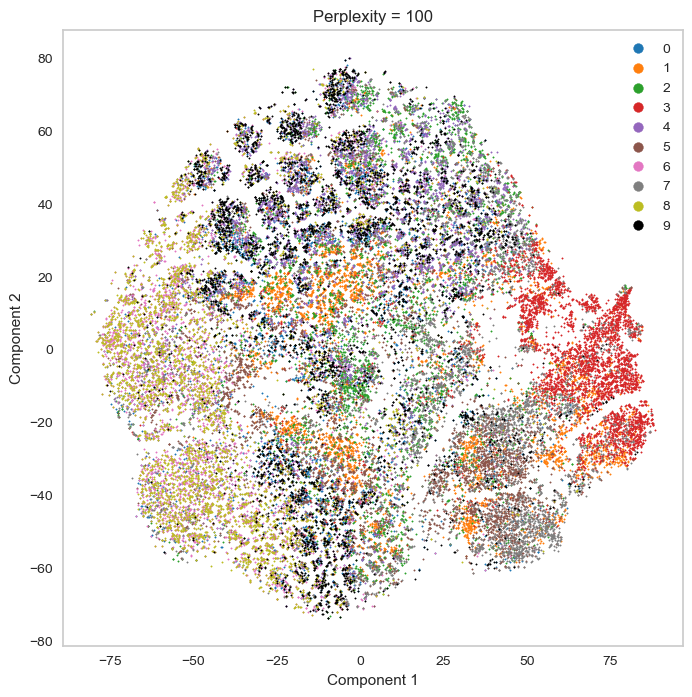

In [116]:
tsne = TSNE(n_components=2, perplexity=100)
X_train_embedded = tsne.fit_transform(X_train)
print(X_train_embedded.shape)
print(tsne.kl_divergence_)

target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_train_embedded[y_train == i, 0], X_train_embedded[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("Perplexity = 100")
plt.show()

In [119]:
umap_model = UMAP(n_neighbors=50, n_components = 2)
umap_model.fit(X_train)
X_umap = umap_model.transform(X_train)

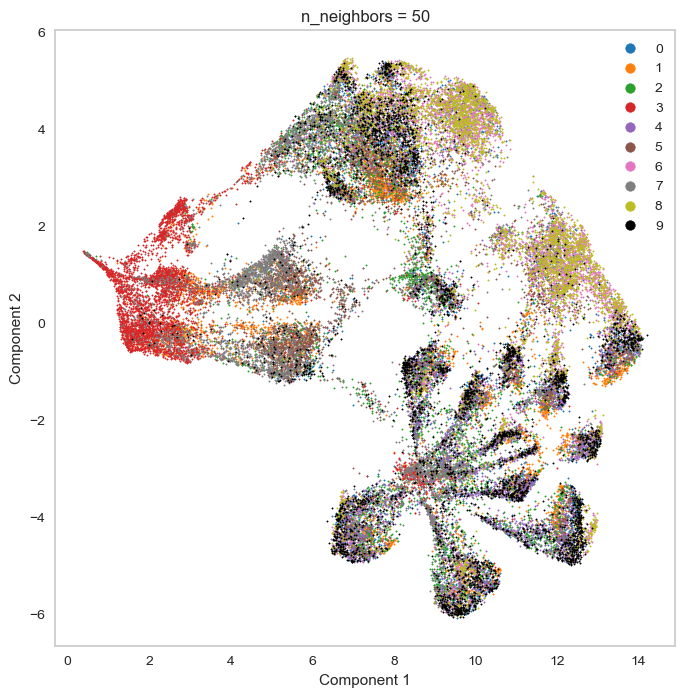

In [120]:
target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("n_neighbors = 50")
plt.show()

In [121]:
umap_model1 = UMAP(n_neighbors=30, n_components = 2)
umap_model1.fit(X_train)
X_umap1 = umap_model1.transform(X_train)

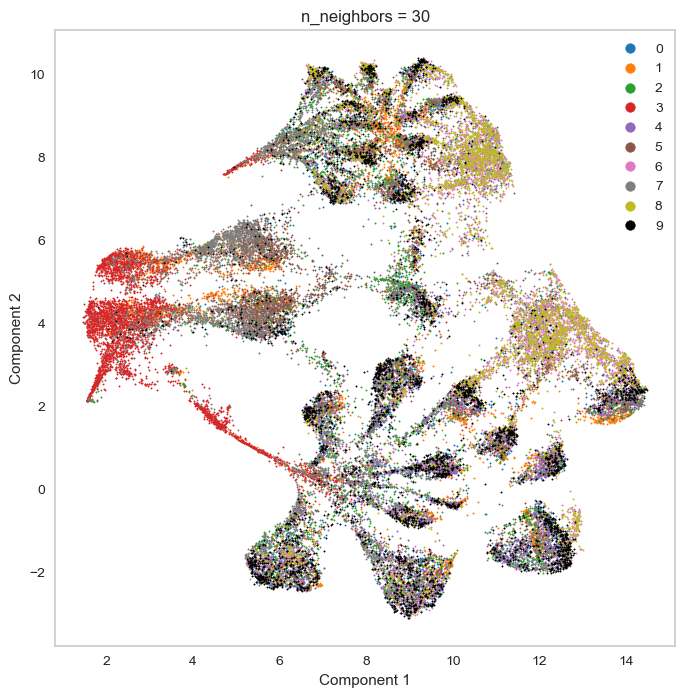

In [122]:
target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_umap1[y_train == i, 0], X_umap1[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("n_neighbors = 30")
plt.show()

In [123]:
umap_model2 = UMAP(n_neighbors=100, n_components = 2)
umap_model2.fit(X_train)
X_umap2 = umap_model2.transform(X_train)

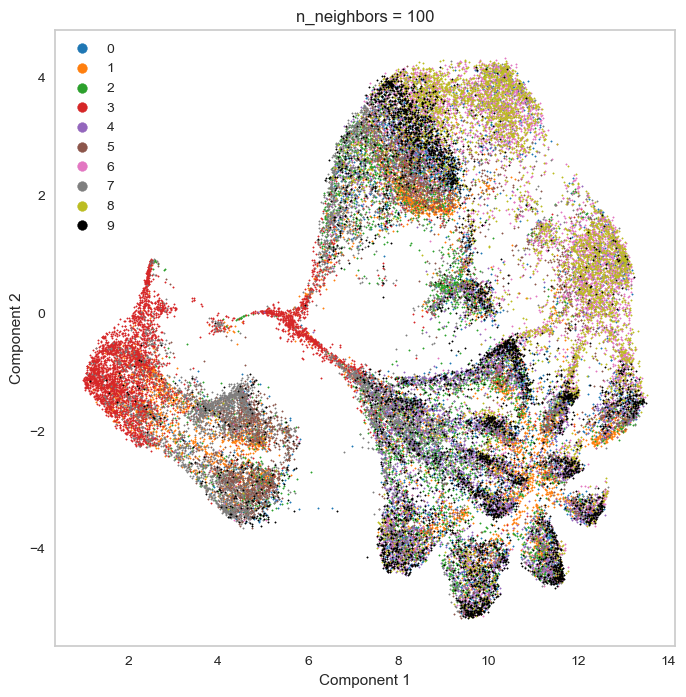

In [124]:
target_ids = range(10)
plt.figure(figsize=(8, 8))
for i, c in zip(target_ids, colors):
    plt.scatter(X_umap2[y_train == i, 0], X_umap2[y_train == i, 1], c=c, label=i,s=1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("n_neighbors = 100")
plt.show()

In [19]:
umap_model_final = UMAP(n_neighbors=30, n_components = 10)
umap_model_final.fit(X_train)
X_umap = umap_model_final.transform(X_train)

<font size="5"> <font color='blue'> Train Randomforest to classify 

In [20]:
umap_model_final.fit(X_test)
X_test_umap = umap_model_final.transform(X_test)

In [21]:
clf = RandomForestClassifier(n_estimators=1000, max_samples=0.6, max_features=0.3,bootstrap=True, criterion='gini')
clf.fit(X_umap, y_train)

RandomForestClassifier(max_features=0.3, max_samples=0.6, n_estimators=1000)

In [28]:
# Predict using the fitted decision tree
preds = clf.predict(X_test_umap)
print(np.sum(preds == y_test)/len(preds))
AUROC = metrics.roc_auc_score(y_test, clf.predict_proba(X_test_umap), multi_class='ovr')
print(AUROC)
AUROC1 = metrics.roc_auc_score(y_test, clf.predict_proba(X_test_umap), multi_class='ovo')
print(AUROC1)

0.2318
0.6637334
0.6637333999999999


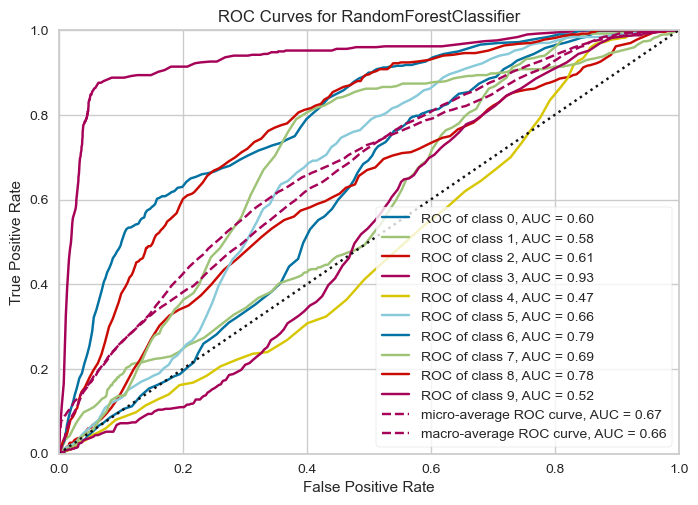

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [30]:
visualizer = ROCAUC(clf, is_fitted=True)
visualizer.fit(X_umap, y_train)
visualizer.score(X_test_umap, y_test)
visualizer.show()  

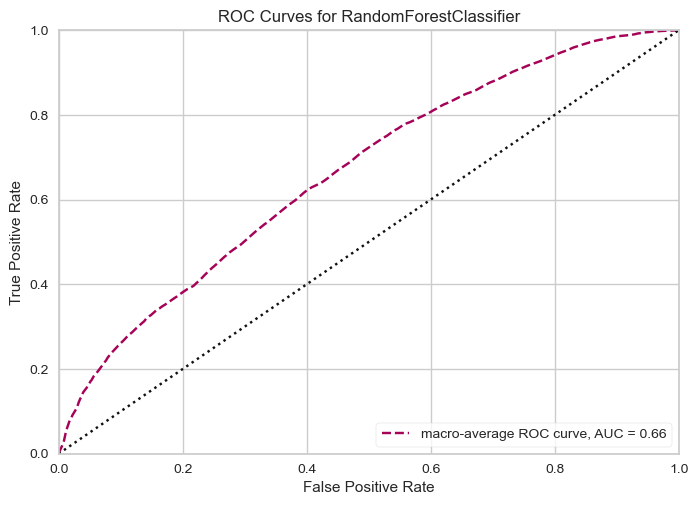

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [31]:
visualizer = ROCAUC(clf, is_fitted=True, macro=True, micro=False, per_class=False)
visualizer.fit(X_umap, y_train)
visualizer.score(X_test_umap, y_test)
visualizer.show()  

In [42]:
umap_model_final1 = UMAP(n_neighbors=50, n_components = 15)
umap_model_final1.fit(X_train)
X_umap1 = umap_model_final1.transform(X_train)

In [43]:
umap_model_final1.fit(X_test)
X_test_umap1 = umap_model_final1.transform(X_test)

In [48]:
clf1 = RandomForestClassifier(n_estimators=1000, max_samples=0.7, max_features=0.3,bootstrap=True, criterion='gini')
clf1.fit(X_umap1, y_train)

RandomForestClassifier(max_features=0.3, max_samples=0.8, n_estimators=1000)

In [49]:
# Predict using the fitted decision tree
preds1 = clf1.predict(X_test_umap1)
print(np.sum(preds1 == y_test)/len(preds1))
AUROC = metrics.roc_auc_score(y_test, clf1.predict_proba(X_test_umap1), multi_class='ovo')
print(AUROC)

0.2228
0.6604149333333333


<font size="5"> <font color='blue'> Train Adaboost to classify

In [82]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=1000, learning_rate=1
)
bdt.fit(X_umap, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=1000)

In [83]:
preds1 = bdt.predict(X_test_umap)
print(np.sum(preds1 == y_test)/len(preds1))

0.1686


<font size="5"> <font color='blue'> Train Deep Neural Network to Classify

In [104]:
D = 10  # input dimensions
C = 10  
H = 30  # num_hidden_units
K = 10
learning_rate = 1e-2
lambda_l2 = 1e-1 

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, K),
    nn.ReLU(),
    nn.Linear(K, C)
)
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
)


In [105]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
X_train_tensor = torch.tensor(X_umap)
y_train_tensor = torch.tensor(y_train.values).long()

# Training loop
for t in range(2000):
    y_pred = model(X_train_tensor) #1
    loss = criterion(y_pred, y_train_tensor) #2
    optimizer.zero_grad() #3
    loss.backward() #4
    optimizer.step() #5

In [106]:
prob = nn.functional.softmax(model(torch.tensor(X_test_umap)), dim=1)
AUROC = metrics.roc_auc_score(y_test, prob.detach().numpy(), multi_class='ovr')
print(AUROC)

0.6468188666666667
